# Named Entity Recognition (NER) in Tensorflow
- NER allows us to identify(tag) all the people, places, companies in a document
- these are called name entities
- this data may be used as a preprocessing step in a larger piece of code
- it exacly works the same way as POS tagging (many-to-many)
- every place has a tag LOC, every person has a tag PER, every company has a tag ORG
- challenge: some entities span multiple tokens (e.g. "Steve" "Jobs")
- "Jobs" by itself means occupation
- another challenge: data is highly imbalanced, most are tagged with O which means it's not a place, person or company
### IOB format
- the idea is each entity potentially appears in a chunk (a sequence of multiple tokens)
- consider Steve Jobs
- for Steve we can use B-PER (begininng of a person chunk)
- for Jobs, we use I-PER (inside of a person chunk)
- Thus, B : Beginning, I: inside, O:outside

#### the code is identical as POS

In [1]:
import pickle #bcz our data for trainset and testset gonna be pickle files
#it's because the data format was a bit different than what we needed so he made some updates 
#and then uploaded them to his website

In [2]:
# dataset called : conll 2003
#probably most popular NER dataset exists
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_test.pkl

File 'ner_train.pkl' already there; not retrieving.

File 'ner_test.pkl' already there; not retrieving.



In [5]:
with open('ner_train.pkl', 'rb') as f:
  corpus_train = pickle.load(f)

with open('ner_test.pkl', 'rb') as f:
  corpus_test = pickle.load(f)

In [6]:
corpus_train

[[('EU', 'B-ORG'),
  ('rejects', 'O'),
  ('German', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('The', 'O'),
  ('European', 'B-ORG'),
  ('Commission', 'I-ORG'),
  ('said', 'O'),
  ('on', 'O'),
  ('Thursday', 'O'),
  ('it', 'O'),
  ('disagreed', 'O'),
  ('with', 'O'),
  ('German', 'B-MISC'),
  ('advice', 'O'),
  ('to', 'O'),
  ('consumers', 'O'),
  ('to', 'O'),
  ('shun', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('until', 'O'),
  ('scientists', 'O'),
  ('determine', 'O'),
  ('whether', 'O'),
  ('mad', 'O'),
  ('cow', 'O'),
  ('disease', 'O'),
  ('can', 'O'),
  ('be', 'O'),
  ('transmitted', 'O'),
  ('to', 'O'),
  ('sheep', 'O'),
  ('.', 'O')],
 [('Germany', 'B-LOC'),
  ("'s", 'O'),
  ('representative', 'O'),
  ('to', 'O'),
  ('the', 'O'),
  ('European', 'B-ORG'),
  ('Union', 'I-ORG'),
  ("'s", 'O'),
  ('veterinary', 'O'),
  ('committee', 'O'),
  ('Werner', 'B-PER'),
  ('Zwingmann', 'I-PER'),
  ('said

In [4]:
train_inputs = []
train_targets = []
#the same code as POS tags
for sentence_tag_pairs in corpus_train:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  train_inputs.append(tokens)
  train_targets.append(target)


In [8]:
test_inputs = []
test_targets = []

for sentence_tag_pairs in corpus_test:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  test_inputs.append(tokens)
  test_targets.append(target)

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [10]:
# Convert sentences to sequences

MAX_VOCAB_SIZE = None

# capitalization might be useful - test it
should_lowercase = False
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK',
)
# otherwise unknown tokens will be removed and len(input) != len(target)
# input words and target words will not be aligned!

# it's ok to "fit" on the whole corpus - it just means some embeddings
# won't be trained
# this is because for the test set, any unknown tokens will be removed
# which will change the length of the input (***CHECK)

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [11]:
# get word -> integer mapping
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 23299 unique tokens.


In [12]:
# https://stackoverflow.com/questions/11264684/flatten-list-of-lists
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [13]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [14]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [15]:
all_train_targets == all_test_targets

True

In [16]:
# Convert targets to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

# save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int


In [17]:
# before padding, find max document length
# because we don't want to truncate any inputs
# which would also truncate targets
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_train, maxlen_test))

In [18]:
# pad sequences so that we get a N x T matrix
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)

Shape of data train tensor: (12733, 113)
Shape of data test tensor: (2970, 113)
Shape of train targets tensor: (12733, 113)
Shape of test targets tensor: (2970, 113)


In [19]:
# number of classes
K = len(tag_tokenizer.word_index) + 1
K

10

In [20]:
# Create the model

# We get to choose embedding dimensionality
D = 32

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
# mask_zero=True way slower on GPU than CPU!
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
# x = SimpleRNN(32, return_sequences=True)(x)
x = Dense(K)(x)

model = Model(i, x)

In [21]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

# 60s per epoch on CPU

print('Training model...')
r = model.fit(
  train_inputs_int,
  train_targets_int,
  epochs=5,
  validation_data=(test_inputs_int, test_targets_int)
)

Training model...
Epoch 1/5


2023-06-22 16:44:26.933082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-22 16:44:30.736956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


398/398 [==============================] - 62s 128ms/step - loss: 0.7166 - accuracy: 0.8370 - val_loss: 0.4892 - val_accuracy: 0.8634
Epoch 2/5
398/398 [==============================] - 52s 132ms/step - loss: 0.3064 - accuracy: 0.9018 - val_loss: 0.3217 - val_accuracy: 0.9108
Epoch 3/5
398/398 [==============================] - 51s 129ms/step - loss: 0.1697 - accuracy: 0.9498 - val_loss: 0.2297 - val_accuracy: 0.9441
Epoch 4/5
398/398 [==============================] - 40s 100ms/step - loss: 0.0858 - accuracy: 0.9786 - val_loss: 0.1956 - val_accuracy: 0.9529
Epoch 5/5
398/398 [==============================] - 42s 104ms/step - loss: 0.0493 - accuracy: 0.9895 - val_loss: 0.1840 - val_accuracy: 0.9565


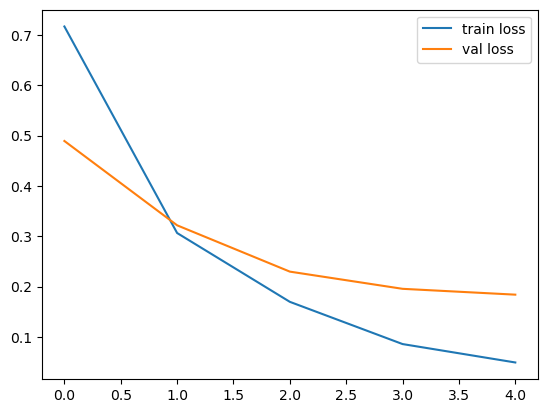

In [22]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

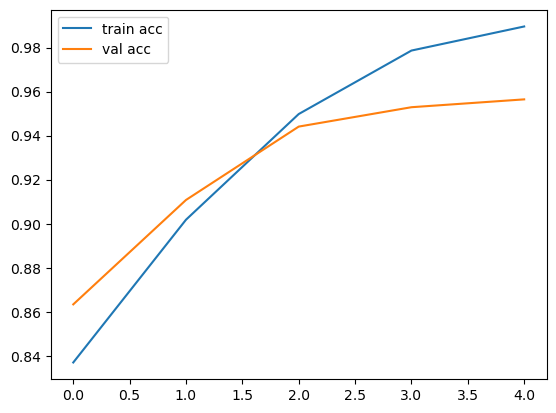

In [23]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [24]:
# True model accuracy - above includes padding

# first get length of each sequence
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))


In [25]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

# flatten
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

398/398 [==============================] - 14s 21ms/step


In [26]:
test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

# flatten
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)


93/93 [==============================] - 2s 19ms/step


In [27]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

#again f1 score is worse, MAY be due to high imbalance so model performing poorly in underrepresented classes

Train acc: 0.9936625178940671
Test acc: 0.9564515811637838
Train f1: 0.9556696843808952
Test f1: 0.8123204709863001


In [28]:
### Baseline model: map word to tag
from collections import Counter

# https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
def most_common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

In [29]:
token2tags = {k: [] for k, v in word2idx.items()}

# remove UNK token
del token2tags['UNK']

for tokens, tags in zip(train_inputs, train_targets):
  for token, tag in zip(tokens, tags):
    if should_lowercase:
      token = token.lower()
    if token in token2tags:
      token2tags[token].append(tag)

for k, v in token2tags.items():
  if len(v) == 0:
    print(k)

token2tag = {k: most_common(v) for k, v in token2tags.items()}

In [30]:
# compute accuracy

train_predictions = []
for sentence in train_inputs:
  predictions = []
  for token in sentence:
    if should_lowercase:
      token = token.lower()
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)


In [31]:
test_predictions = []
for sentence in test_inputs:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token, 'INCORRECT')
    predictions.append(predicted_tag)
  test_predictions.append(predictions)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)


In [32]:
print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

#again baseline is simply memorize the most common tag for each, without paying attention to context
#performs much poorly
#hence we can conclude that our model is succesful n can use model to predict named entities

Train acc: 0.974769365357086
Test acc: 0.8881673455733318
Train f1: 0.8549353965547479
Test f1: 0.6381158268902334


## EXERCISE: return to CNNs
- we've used RNNs for many-to-many tasks
- question: can we use CNNs as well for many-to-many tasks? (like POS-tagging or NER)
- you may think this is easy, just to switch to Conv1D and LSTM
- however, in fact an advanced challenging exercise
- Hints:
    - you know size of the data can change as you go along with layers of CNN but we don't want it since output must have the same lenght as input, so consider how the CNN architecture should be such that sequence lentgh won't change
    - we know we'll need some way to ignore padded tokens so that they won't be included in the loss, for RNNs we mentioned 2 methods (mask_zero or custom loss), you'll need to find out which of these options work in the convolution, as a small hint this might be more difficult than you assume
    - hatırla bu hatalara rağmen notebook 99% accuracy verebiliyodu
- Questions to consider:
- how CNN performs compared to RNN?
- how training and inference times compare?
- which would you choose for a realworld project